# closefriends

A Python package for finding pairs of points within a fixed distance utilising the [Cell Lists](https://en.wikipedia.org/wiki/Cell_lists)
strategy and sorting to improve sequential iteration over the pair list (like described [here](https://developer.download.nvidia.com/assets/cuda/files/particles.pdf)).

## Motivation

In the Python world, there is already the well-established KDTree sub-module for finding pairs of points within an
arbitrary-dimensioned particle cloud. This is not the optimal algorithm to use such as in particle-/point-based
numerical methods, like in Smoothed Particle Hydrodynamics (SPH) used for CFD. For this particular case, closefriends
can be 1.5 to 3 times faster than using `scipy.KDTree.query_pairs`.

## Usage

The `closefrieds.query_pairs` function accepts a 2D Numpy `ndarray` where rows represent each point, and colums
represent particles' coordinates.

In [2]:
import numpy as np, closefriends

dim = 2      # 3 spatial dimensions
npoints = 100 # 10 points
r = 0.2      # cutoff distance
maxnpair = 1000 # estimated pairs per points
maxnpair = int(maxnpair)

# generating random points with coordinates between 0 and 1
rng = np.random.default_rng(12345)
x = rng.random(dim*npoints).reshape((npoints, dim))

# finding pairs using closefriends.query_pairs
pairs = closefriends.query_pairs(x, r, maxnpair, output_type="set", retain_order=True)

print(f"printing 10/{len(pairs)} pairs (set of tuples):")
for i, pair in enumerate(pairs):
    print(pair)
    if i > 9: break

printing 10/561 pairs (set of tuples):
(1, 86)
(47, 53)
(16, 93)
(67, 77)
(36, 71)
(8, 9)
(9, 63)
(5, 74)
(21, 37)
(0, 23)
(11, 23)


### Sorting strategy

Closefriends sorts the position using a grid by mapping each gridcell into a single integer. The positions are then sorted by these hashes. The benefit is that it improves data locality, i.e., points that are located nearby, are also located nearby in memory. This makes it faster to iterate over the list of pairs. 

The hashing algorithm here is simple, and doesn't aim to improve data locality the most. This is because the simple hashing algorithm used here enables more elegant design of the pair search algorithm. 

Re-ordering of the points is enabled by default, and can be turned off by passing `retain_ordering = True` to the `query_pairs` function call. Note that `retain_ordering = True` also ensures that for each pair, `i < j` - for comatibility with `scipy.KDTree.query_pairs`.

To see how the data is reordered, consider the configuration below:

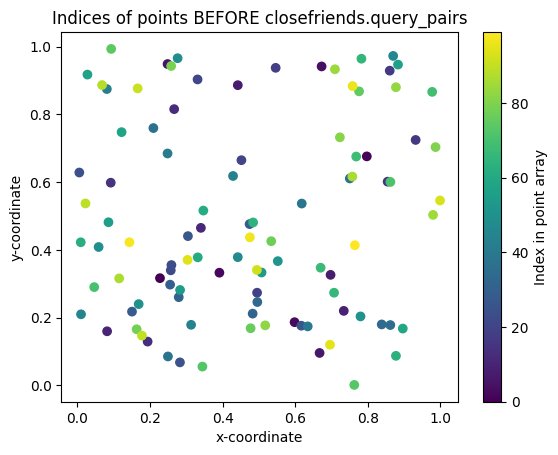

In [18]:
import matplotlib.pyplot as plt

ax = plt.scatter(x[:, 0], x[:, 1], c=np.arange(npoints))
cb = plt.colorbar(ax, label="Index in point array")
txt = plt.title("Indices of points BEFORE closefriends.query_pairs")
txt = plt.xlabel("x-coordinate")
txt = plt.ylabel("y-coordinate")

When running `closefriends.query_pairs` on this array of points, the particles are reordered, so the points located lower in x and then y directions are located "earlier" in the array.

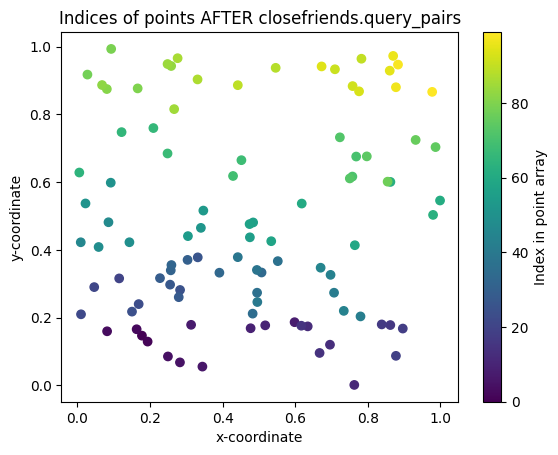

In [19]:
pairs, idx = closefriends.query_pairs(x, r, maxnpair)

ax = plt.scatter(x[:, 0], x[:, 1], c=np.arange(npoints))
cb = plt.colorbar(ax, label="Index in point array")
txt = plt.title("Indices of points AFTER closefriends.query_pairs")
txt = plt.xlabel("x-coordinate")
txt = plt.ylabel("y-coordinate")

For your convenience, the `idx` array is returned, which tells you the old index of each point in the modified array. For example, if `idx[0]` is equal to `10`, this means that the point located at the position 0, used to be located at position 10. This should allow you to reorder other data as needed.

### NDArray output

Like `scipy.KDTree.query_pairs`, the output can be returned either as a set of tuples, or a 2D ndarray. The latter is the default, as it is faster to iterate over sequentially. Return a `set` by passing `output_type = "set"`. Or explicitly ask for an NDArray to be returned with `output_type = "ndarray"`.